# **Digital Signal and Image Management - 2D Signal Processing**<br/>

---

#Facial Expression Recognition

Authors:

Luca Galli - 905236 | Davide Ronchi - 903320

---



# Contents

The aim of this notebook is to try different model architectures to perform Facial Expression Recognition.

We start by loading the pre-processed data and to prepare them for the models training.

Models trained includes:
* **CNN1**: consists of three convolutional blocks, each with a Conv2D layer followed by an activation and pooling layer, culminating in a dense layer to output the probability distribution for each class.

* **CNN2**: has the same architecture of CNN1, but introduces regularization and dropout compared to the previous model. Each convolutional block includes L2 regularization to prevent overfitting and a Dropout layer set at 17.5% to reduce the risk of overfitting by randomly deactivating neurons during training. These additions help improve the model's generalization capabilities.

* **Residual Network**: is a residual neural network (ResNet) model with L2 regularization and batch normalization. It consists of 4 residual blocks, each composed of convolutional layers with relu activations, followed by batch normalization. Each block includes a shortcut connection to facilitate learning deeper representations effectively.

* **Transfer Learning**: we will also use a pretrained model, in particular [EfficientNetV2B0](https://keras.io/api/applications/efficientnet/#:~:text=%5Bsource%5D-,EfficientNetB0%20function,-keras.applications), as feature extractor by freezing it. After the EfficientNet as base model, Global average pooling is applied to reduce spatial dimensions, followed by dropout regularization to mitigate overfitting. Then two dense layers with ReLU activation and L2 regularization further process the features before the final output layer.

* **Fine-Tuning**: After training the model we unfreezed all parts of the base model and retrained the whole model end-to-end with a very low learning rate to obtain further improvements on performances.

All the models have been trained using [Kullback-Leibler divergence](https://keras.io/api/losses/probabilistic_losses/#kldivergence-class:~:text=%5Bsource%5D-,KLDivergence,-class), which measures how one probability distribution diverges from a second expected probability distribution, since we are not dealing with a classification task.

Then we compared the models using different metrics

## Importing Libraries

In [ ]:
# General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random
import pandas as pd
import scipy
import os, os.path
from io import StringIO
import re
import seaborn as sns
from tqdm import tqdm

# File handling
import tarfile
import pickle

# Image Processing
from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import cosine_similarity

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting seed for reproducibility

In [ ]:
seed = 123456

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Data Loading

Define base path

In [ ]:
base_path = "/content/drive/MyDrive/DSaIM_project/2D/Data/"

Importing Data from Pickle files

In [ ]:
with open(base_path + "y_train.pkl", 'rb') as f:
    y_train = pickle.load(f)

with open(base_path + "y_val.pkl", 'rb') as f:
    y_val = pickle.load(f)

with open(base_path + "y_test.pkl", 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
with open(base_path + "X_train.pkl", 'rb') as f:
    X_train = pickle.load(f)

with open(base_path + "X_val.pkl", 'rb') as f:
    X_val = pickle.load(f)

with open(base_path + "X_test.pkl", 'rb') as f:
    X_test = pickle.load(f)

Reshape variables

In [ ]:
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min()}, \tmax value: {X_train.max()}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min()}, \tmax value: {X_val.max()}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min()}, \tmax value: {X_test.max()}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(28442, 48, 48, 1),	min value: 0.0, 	max value: 255.0
y_train shape: 	(28442, 9)
X_val shape: 	(3567, 48, 48, 1),	min value: 0.0, 	max value: 255.0
y_val shape: 	(3567, 9)
X_test shape: 	(3517, 48, 48, 1),	min value: 0.0, 	max value: 255.0
y_test shape: 	(3517, 9)


Normalize data

In [ ]:
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

## CNN1 Probability

In [ ]:
input_shape = (X_train_norm.shape[1], X_train_norm.shape[2], X_train_norm.shape[3])
num_classes = y_train.shape[1]
print(f"Input shape:\t\t{input_shape}\nNumber of classes:\t{num_classes}")

Input shape:		(48, 48, 1)
Number of classes:	9


### CNN1_probability - Definition

In [ ]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(input_shape)
    x = inputs

    # First Convolutional Block
    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

    # Second Convolutional Block
    x = keras.layers.Conv2D(64, 3, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

    # Third Convolutional Block
    x = keras.layers.Conv2D(128, 3, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.GlobalMaxPooling2D()(x)

    # Dense Layer
    x = keras.layers.Dense(64, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='CNN1_probability')
    return model

In [ ]:
CNN1_probability = create_model(input_shape, num_classes)
CNN1_probability.summary()

Model: "CNN1_probability"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_3 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 activation_4 (Activation)   (None, 16, 16, 64)        0         
                                                  

### CNN1_probability - Parameters and Callbacks

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 100
batch_size = 64

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.KLDivergence()

Callbacks

In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
CNN1_probability_checkpoint_filepath = base_path + 'Models/CNN1_probability_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(CNN1_probability_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/CNN1_probability")

# CSV Logger for history saving
history_CNN1_probability_filepath = base_path + 'backup/history_CNN1_probability.csv'
callback_CVS = keras.callbacks.CSVLogger(history_CNN1_probability_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

Compile Model

In [ ]:
CNN1_probability.compile(optimizer=optimizer, loss=loss_function)

### CNN1_probability - Training

Data Augmentation

In [ ]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # randomly rotate images by 15 degrees
    width_shift_range=0.1,   # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # randomly shift images vertically by up to 10%
    shear_range=0.1,         # randomly apply shear transformation with a maximum shear intensity of 10%
    zoom_range=0.1,          # randomly zoom into images by up to 10%
    horizontal_flip=True,    # randomly flip images horizontally
    fill_mode='nearest'      # fill in newly created pixels after rotation or width/height shift
)

In [ ]:
# Train the model
history_CNN1_probability = CNN1_probability.fit(datagen.flow(X_train_norm, y_train, batch_size=batch_size),
                                                epochs=epochs,
                                                steps_per_epoch=len(X_train_norm) // batch_size,
                                                validation_data=(X_val_norm, y_val),
                                                callbacks=callbacks)

Epoch 1/100
444/444 [==============================] - ETA: 0s - loss: 1.1437
Epoch 1: val_loss improved from inf to 1.11044, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/CNN1_probability_checkpoint.keras
444/444 [==============================] - 18s 38ms/step - loss: 1.1437 - val_loss: 1.1104 - lr: 0.0010
Epoch 2/100
444/444 [==============================] - ETA: 0s - loss: 0.9970
Epoch 2: val_loss improved from 1.11044 to 0.89961, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/CNN1_probability_checkpoint.keras
444/444 [==============================] - 20s 45ms/step - loss: 0.9970 - val_loss: 0.8996 - lr: 0.0010
Epoch 3/100
444/444 [==============================] - ETA: 0s - loss: 0.8624
Epoch 3: val_loss improved from 0.89961 to 0.78146, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/CNN1_probability_checkpoint.keras
444/444 [==============================] - 21s 48ms/step - loss: 0.8624 - val_loss: 0.7815 - lr: 0.0

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_CNN1_probability_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()

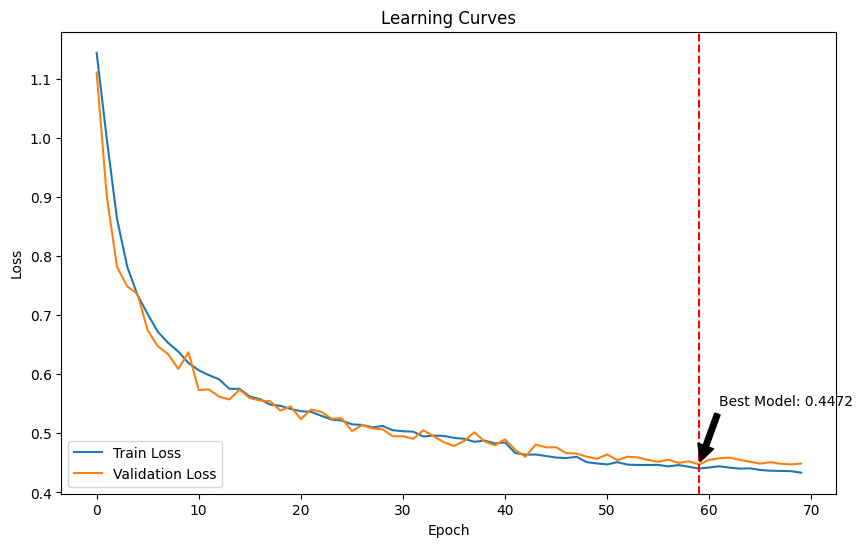

In [ ]:
plt.figure(figsize=(10, 6))

# Loss
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),  # Adjust these values to place the text properly
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Learning Curves')
plt.show()

## CNN2 Probability

In [ ]:
input_shape = (X_train_norm.shape[1], X_train_norm.shape[2], X_train_norm.shape[3])
num_classes = y_train.shape[1]
print(f"Input shape:\t\t{input_shape}\nNumber of classes:\t{num_classes}")

Input shape:		(48, 48, 1)
Number of classes:	9


### CNN2 - Definition

In [ ]:
def create_model(input_shape, num_classes):
    # New architecture with regularization
    inputs = keras.Input(input_shape)
    x = inputs

    # First Convolutional Block
    x = keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)
    x = keras.layers.Dropout(0.175)(x)

    # Second Convolutional Block
    x = keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)
    x = keras.layers.Dropout(0.175)(x)


    # Third Convolutional Block
    x = keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.GlobalMaxPooling2D()(x)
    x = keras.layers.Dropout(0.175)(x)


    # Dense Layer
    x = keras.layers.Dense(64, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='CNN2_probability')
    return model

In [ ]:
CNN2_probability = create_model(input_shape, num_classes)
CNN2_probability.summary()

Model: "CNN2_probability"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                  

### CNN2 - Parameters and Callbacks

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 100
batch_size = 64

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.KLDivergence()

Callbacks

In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
CNN2_probability_checkpoint_filepath = base_path + 'Models/CNN2_probability_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(CNN2_probability_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/CNN2_probability")

# CSV Logger for history saving
history_CNN2_probability_filepath = base_path + 'backup/history_CNN2_probability.csv'
callback_CVS = keras.callbacks.CSVLogger(history_CNN2_probability_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

Compile Model

In [ ]:
CNN2_probability.compile(optimizer=optimizer, loss=loss_function)

### CNN2 - Training

Data Augmentation

In [ ]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # randomly rotate images by 15 degrees
    width_shift_range=0.1,   # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # randomly shift images vertically by up to 10%
    shear_range=0.1,         # randomly apply shear transformation with a maximum shear intensity of 10%
    zoom_range=0.1,          # randomly zoom into images by up to 10%
    horizontal_flip=True,    # randomly flip images horizontally
    fill_mode='nearest'      # fill in newly created pixels after rotation or width/height shift
)

In [ ]:
# Train the model
history_CNN2_probability = CNN2_probability.fit(datagen.flow(X_train_norm, y_train, batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=len(X_train_norm) // batch_size,
                        validation_data=(X_val_norm, y_val),
                        callbacks=callbacks)

Epoch 1/100
443/444 [============================>.] - ETA: 0s - loss: 1.2359
Epoch 1: val_loss improved from inf to 1.25333, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/CNN2_probability_checkpoint.keras
444/444 [==============================] - 30s 62ms/step - loss: 1.2357 - val_loss: 1.2533 - lr: 0.0010
Epoch 2/100
443/444 [============================>.] - ETA: 0s - loss: 1.1844
Epoch 2: val_loss improved from 1.25333 to 1.23750, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/CNN2_probability_checkpoint.keras
444/444 [==============================] - 16s 36ms/step - loss: 1.1845 - val_loss: 1.2375 - lr: 0.0010
Epoch 3/100
444/444 [==============================] - ETA: 0s - loss: 1.1723
Epoch 3: val_loss improved from 1.23750 to 1.22284, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/CNN2_probability_checkpoint.keras
444/444 [==============================] - 16s 36ms/step - loss: 1.1723 - val_loss: 1.2228 - lr: 0.0

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_CNN2_probability_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()

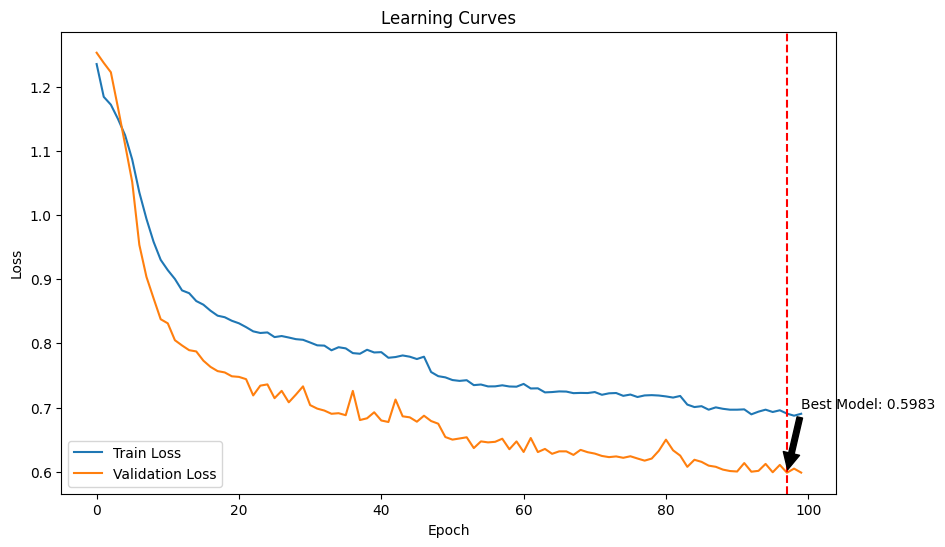

In [ ]:
plt.figure(figsize=(10, 6))

# Loss
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),  # Adjust these values to place the text properly
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Learning Curves')
plt.show()

## Residual Network Probability

In [ ]:
input_shape = (X_train_norm.shape[1], X_train_norm.shape[2], X_train_norm.shape[3])
num_classes = y_train.shape[1]
print(f"Input shape:\t\t{input_shape}\nNumber of classes:\t{num_classes}")

Input shape:		(48, 48, 1)
Number of classes:	9


### Residual Network - Definition

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x
    if conv_shortcut:
        shortcut = keras.layers.Conv2D(filters, 1, strides=stride, padding='same',
                                       kernel_regularizer=keras.regularizers.l2(0.001))(x)
        shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                            kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(filters, kernel_size, padding='same',
                            kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Add()([shortcut, x])
    x = keras.layers.Activation('relu')(x)
    return x

def create_model(input_shape, num_classes):
    inputs = keras.Input(input_shape)

    # Initial Convolutional Layer
    x = keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # First Residual Block
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Second Residual Block
    x = residual_block(x, 64, conv_shortcut=True)
    x = residual_block(x, 64)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Third Residual Block
    x = residual_block(x, 128, conv_shortcut=True)
    x = residual_block(x, 128)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth Residual Block with Max Pooling
    x = residual_block(x, 256, conv_shortcut=True)
    x = residual_block(x, 256)
    x = keras.layers.GlobalMaxPooling2D()(x)

    # Dense Layers
    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.4)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='res_model_probability')
    return model

In [ ]:
res_model_probability = create_model(input_shape, num_classes)
res_model_probability.summary()

Model: "res_model_probability"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 48, 48, 32)           0         ['batch_no

### Residual network - Parameters and Callbacks

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 100
batch_size = 64

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.KLDivergence()

Callbacks


In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
res_model_probability_checkpoint_filepath = base_path + 'Models/res_model_probability_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(res_model_probability_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/res_model_probability")

# CSV Logger for history saving
history_res_model_probability_filepath = base_path + 'backup/history_res_model_probability.csv'
callback_CVS = keras.callbacks.CSVLogger(history_res_model_probability_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

In [ ]:
res_model_probability.compile(optimizer=optimizer, loss=loss_function)

### Residual Network - Training

In [ ]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # randomly rotate images by 15 degrees
    width_shift_range=0.1,   # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # randomly shift images vertically by up to 10%
    shear_range=0.1,         # randomly apply shear transformation with a maximum shear intensity of 10%
    zoom_range=0.1,          # randomly zoom into images by up to 10%
    horizontal_flip=True,    # randomly flip images horizontally
    fill_mode='nearest'      # fill in newly created pixels after rotation or width/height shift
)

In [ ]:
# Train the model
history_res_model_probability = res_model_probability.fit(datagen.flow(X_train_norm, y_train, batch_size=batch_size),
                                                          epochs=epochs,
                                                          steps_per_epoch=len(X_train_norm) // batch_size,
                                                          validation_data=(X_val_norm, y_val),
                                                          callbacks=callbacks)

Epoch 1/100
444/444 [==============================] - ETA: 0s - loss: 0.4473
Epoch 1: val_loss improved from 0.47336 to 0.47311, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/res_model_probability_checkpoint.keras
444/444 [==============================] - 45s 102ms/step - loss: 0.4473 - val_loss: 0.4731 - lr: 3.9063e-06
Epoch 2/100
443/444 [============================>.] - ETA: 0s - loss: 0.4474
Epoch 2: val_loss did not improve from 0.47311
444/444 [==============================] - 26s 59ms/step - loss: 0.4475 - val_loss: 0.4732 - lr: 3.9063e-06
Epoch 3/100
444/444 [==============================] - ETA: 0s - loss: 0.4505
Epoch 3: val_loss improved from 0.47311 to 0.47286, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/res_model_probability_checkpoint.keras
444/444 [==============================] - 26s 59ms/step - loss: 0.4505 - val_loss: 0.4729 - lr: 3.9063e-06
Epoch 4/100
444/444 [==============================] - ETA: 0s - loss: 0.445

KeyboardInterrupt: 

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_res_model_probability_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()

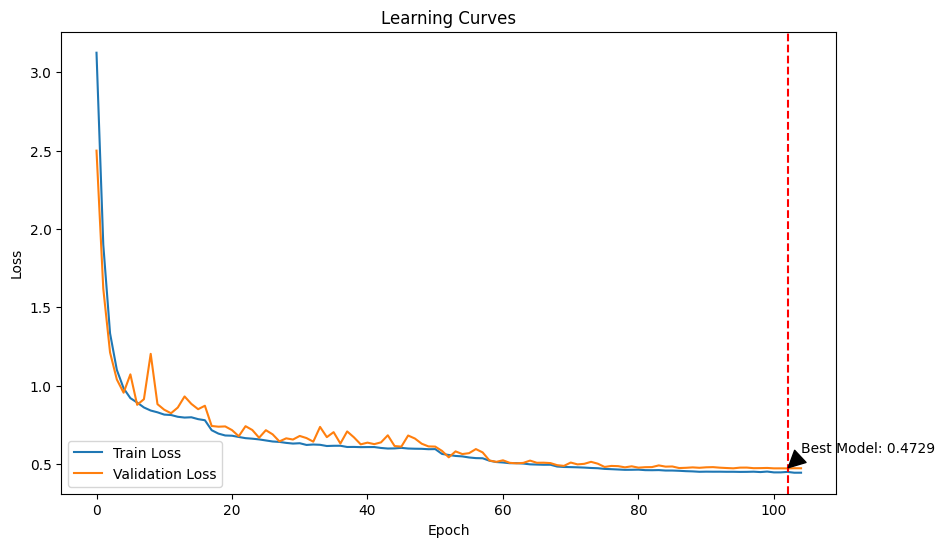

In [ ]:
plt.figure(figsize=(10, 6))

# Loss
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),  # Adjust these values to place the text properly
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Learning Curves')
plt.show()

## Transfer learning - EfficientNet Probability

### EfficientNet - Definition

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = y_train.shape[1]
print(f"Input shape:\t\t{input_shape}\nNumber of classes:\t{num_classes}")

Input shape:		(48, 48, 1)
Number of classes:	9


Loading the base model

In [ ]:
base_model = keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

In [ ]:
def create_model(input_shape, num_classes, base_model):
    inputs = tf.keras.Input(shape=input_shape)
    # Upsample from (48,48) to (224,224)
    x = tf.image.resize(inputs, (224, 224))
    # Convert to RGB
    x = tf.keras.layers.Concatenate()([x, x, x])

    # Preprocess input for Resnet
    x = keras.applications.efficientnet_v2.preprocess_input(x)

    # Pass through the base model
    x = base_model(x, training=False)

    # Custom layers
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs, outputs, name='EfficientNet')

    return model

In [ ]:
EfficientNet_model_probability = create_model(input_shape, num_classes, base_model)
EfficientNet_model_probability.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 tf.image.resize (TFOpLambd  (None, 224, 224, 1)          0         ['input_2[0][0]']             
 a)                                                                                               
                                                                                                  
 concatenate (Concatenate)   (None, 224, 224, 3)          0         ['tf.image.resize[0][0]',     
                                                                     'tf.image.resize[0][0]',     
                                                                     'tf.image.resize[0

### EfficientNet - Parameters and Callbacks

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 100
batch_size = 64

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.KLDivergence()

callbacks

In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
EfficientNet_model_probability_checkpoint_filepath = base_path + 'Models/EfficientNet_model_probability_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(EfficientNet_model_probability_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/EfficientNet_model_probability")

# CSV Logger for history saving
history_EfficientNet_model_probability_filepath = base_path + 'backup/history_EfficientNet_model_probability.csv'
callback_CVS = keras.callbacks.CSVLogger(history_EfficientNet_model_probability_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

In [ ]:
EfficientNet_model_probability.compile(optimizer=optimizer, loss=loss_function)

### EfficientNet - Training

Data Augmentation

In [ ]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # randomly rotate images by 15 degrees
    width_shift_range=0.1,   # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # randomly shift images vertically by up to 10%
    shear_range=0.1,         # randomly apply shear transformation with a maximum shear intensity of 10%
    zoom_range=0.1,          # randomly zoom into images by up to 10%
    horizontal_flip=True,    # randomly flip images horizontally
    fill_mode='nearest'      # fill in newly created pixels after rotation or width/height shift
)

In [ ]:
# Train the model
history_EfficientNet_model_probability = EfficientNet_model_probability.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                                                                            epochs=epochs,
                                                                            steps_per_epoch=len(X_train) // batch_size,
                                                                            validation_data=(X_val, y_val),
                                                                            callbacks=callbacks)

Epoch 1/100
444/444 [==============================] - ETA: 0s - loss: 1.4528
Epoch 1: val_loss improved from inf to 1.00915, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/EfficientNet_model_probability_checkpoint.keras
444/444 [==============================] - 80s 117ms/step - loss: 1.4528 - val_loss: 1.0092 - lr: 0.0010
Epoch 2/100
444/444 [==============================] - ETA: 0s - loss: 0.9839
Epoch 2: val_loss improved from 1.00915 to 0.91550, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/EfficientNet_model_probability_checkpoint.keras
444/444 [==============================] - 53s 119ms/step - loss: 0.9839 - val_loss: 0.9155 - lr: 0.0010
Epoch 3/100
444/444 [==============================] - ETA: 0s - loss: 0.9281
Epoch 3: val_loss improved from 0.91550 to 0.85186, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/EfficientNet_model_probability_checkpoint.keras
444/444 [==============================] - 44s 100ms/ste

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_EfficientNet_model_probability_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()

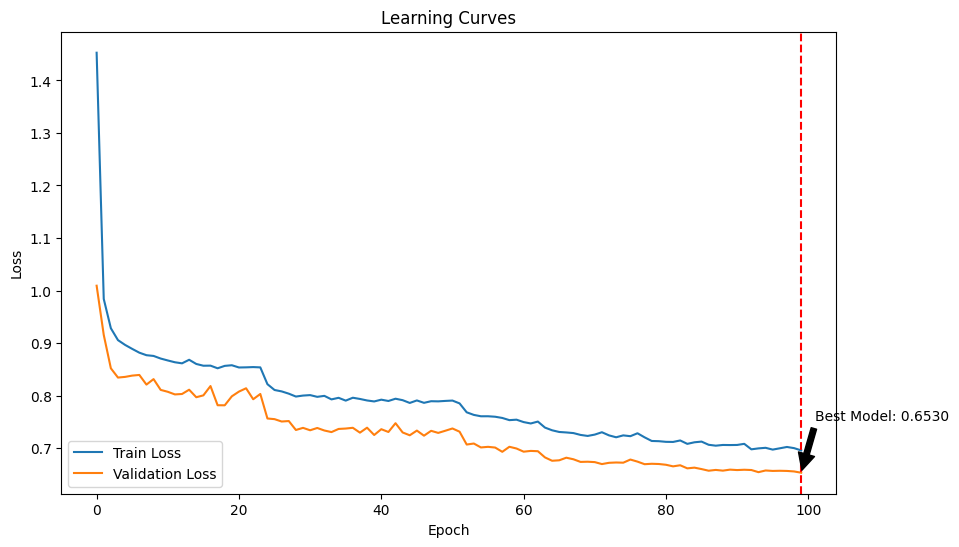

In [ ]:
plt.figure(figsize=(10, 6))

# Loss
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),  # Adjust these values to place the text properly
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Learning Curves')
plt.show()

### EfficientNet_model_probability - Fine Tuning

In [ ]:
EfficientNet_model_probability_ft = tf.keras.models.load_model(EfficientNet_model_probability_checkpoint_filepath)

In [ ]:
# Unfreeze the base model
EfficientNet_model_probability_ft.trainable = True

In [ ]:
# Hyperparameters
lr = 1e-5
epochs = 15
batch_size = 64

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.KLDivergence()

In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
EfficientNet_model_probability_ft_checkpoint_filepath = base_path + 'Models/EfficientNet_model_probability_ft_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(EfficientNet_model_probability_ft_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/EfficientNet_model_probability_ft")

# CSV Logger for history saving
history_EfficientNet_model_probability_ft_filepath = base_path + 'backup/history_EfficientNet_model_probability_ft.csv'
callback_CVS = keras.callbacks.CSVLogger(history_EfficientNet_model_probability_ft_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

In [ ]:
EfficientNet_model_probability_ft.compile(optimizer=optimizer, loss=loss_function)
EfficientNet_model_probability_ft.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 tf.image.resize (TFOpLambd  (None, 224, 224, 1)          0         ['input_2[0][0]']             
 a)                                                                                               
                                                                                                  
 concatenate (Concatenate)   (None, 224, 224, 3)          0         ['tf.image.resize[0][0]',     
                                                                     'tf.image.resize[0][0]',     
                                                                     'tf.image.resize[0

In [ ]:
# Train end-to-end. Be careful to stop before you overfit!
history_EfficientNet_model_probability_ft = EfficientNet_model_probability_ft.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                                                                                  epochs=epochs,
                                                                                  steps_per_epoch=len(X_train) // batch_size,
                                                                                  validation_data=(X_val, y_val),
                                                                                  callbacks=callbacks)

Epoch 1/15
444/444 [==============================] - ETA: 0s - loss: 0.6346
Epoch 1: val_loss improved from inf to 0.56814, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/EfficientNet_model_probability_ft_checkpoint.keras
444/444 [==============================] - 239s 416ms/step - loss: 0.6346 - val_loss: 0.5681 - lr: 1.0000e-05
Epoch 2/15
444/444 [==============================] - ETA: 0s - loss: 0.5836
Epoch 2: val_loss improved from 0.56814 to 0.53589, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/EfficientNet_model_probability_ft_checkpoint.keras
444/444 [==============================] - 162s 365ms/step - loss: 0.5836 - val_loss: 0.5359 - lr: 1.0000e-05
Epoch 3/15
444/444 [==============================] - ETA: 0s - loss: 0.5548
Epoch 3: val_loss improved from 0.53589 to 0.51785, saving model to /content/drive/MyDrive/DSaIM_project/2D/Data/Models/EfficientNet_model_probability_ft_checkpoint.keras
444/444 [==============================]

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_EfficientNet_model_probability_ft_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()

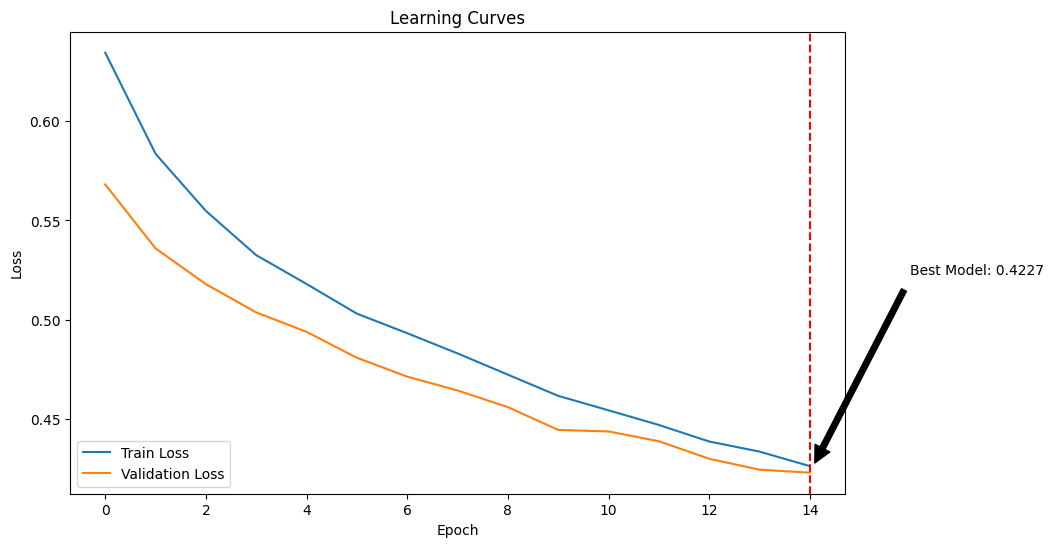

In [ ]:
plt.figure(figsize=(10, 6))

# Loss
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),  # Adjust these values to place the text properly
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Learning Curves')
plt.show()

## Model Comparison

In [ ]:
# Models Paths
CNN1_probability_checkpoint_filepath = base_path + 'Models/CNN1_probability_checkpoint.keras'
CNN2_probability_checkpoint_filepath = base_path + 'Models/CNN2_probability_checkpoint.keras'
res_model_probability_checkpoint_filepath = base_path + 'Models/res_model_probability_checkpoint.keras'
EfficientNet_model_probability_ft_checkpoint_filepath = base_path + 'Models/EfficientNet_model_probability_ft_checkpoint.keras'

# Load models
CNN1_probability = keras.models.load_model(CNN1_probability_checkpoint_filepath)
CNN2_probability = keras.models.load_model(CNN2_probability_checkpoint_filepath)
res_model_probability = keras.models.load_model(res_model_probability_checkpoint_filepath)
EfficientNet_model_probability_ft = keras.models.load_model(EfficientNet_model_probability_ft_checkpoint_filepath)

In [ ]:
models = [CNN1_probability, CNN2_probability, res_model_probability, EfficientNet_model_probability_ft]
model_names = ["CNN1", "CNN2", "Residual network", "EfficientNet"]

metrics = {
    "Model": [],
    "Test Loss": [],
    "MSE": [],
    "MAE": [],
    "Cosine Similarity": [],
    "JSD": []
}

In [ ]:
for i, model in enumerate(models):
    if model == EfficientNet_model_probability_ft:
      # Evaluate loss and accuracy
      test_loss = model.evaluate(X_test, y_test, verbose=0)
      # Get predictions
      y_pred = model.predict(X_test)
      print(f"Evaluated model {i}: {model}")
    else:
      # Evaluate loss and accuracy
      test_loss = model.evaluate(X_test_norm, y_test, verbose=0)
      # Get predictions
      y_pred = model.predict(X_test_norm)
      print(f"Evaluated model {i}: {model}")

    # Calculate additional metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    cos_sim = np.mean([cosine_similarity(y_test[j].reshape(1, -1), y_pred[j].reshape(1, -1))[0, 0] for j in range(len(y_test))])
    jsd = np.mean([jensenshannon(y_test[j], y_pred[j]) for j in range(len(y_test))])

    # Store the results
    metrics["Model"].append(model_names[i])
    metrics["Test Loss"].append(test_loss)
    metrics["MSE"].append(mse)
    metrics["MAE"].append(mae)
    metrics["Cosine Similarity"].append(cos_sim)
    metrics["JSD"].append(jsd)

110/110 [==============================] - 2s 23ms/step
Evaluated model 0: <keras.src.engine.functional.Functional object at 0x7acaf0db0250>
110/110 [==============================] - 3s 31ms/step
Evaluated model 1: <keras.src.engine.functional.Functional object at 0x7acaf0e26a10>
110/110 [==============================] - 55s 487ms/step
Evaluated model 2: <keras.src.engine.functional.Functional object at 0x7acaf0552470>
110/110 [==============================] - 224s 2s/step
Evaluated model 3: <keras.src.engine.functional.Functional object at 0x7acaaa43a350>


In [ ]:
# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Print or display the DataFrame
metrics_df

,Model,Test Loss,MSE,MAE,Cosine Similarity,JSD
2,CNN1,0.450045,0.015258,0.063621,0.866924,0.305166
3,CNN2,0.580807,0.019219,0.075338,0.834764,0.346309
4,Residual network,0.447722,0.012044,0.063708,0.900980,0.316528
5,EfficientNet,0.406943,0.011380,0.054983,0.898163,0.278139


We can see that the EfficientNet have better performances for all the metrics with respect to the others, excepts for the cosine similarity in which the Residual Network is slightly better.